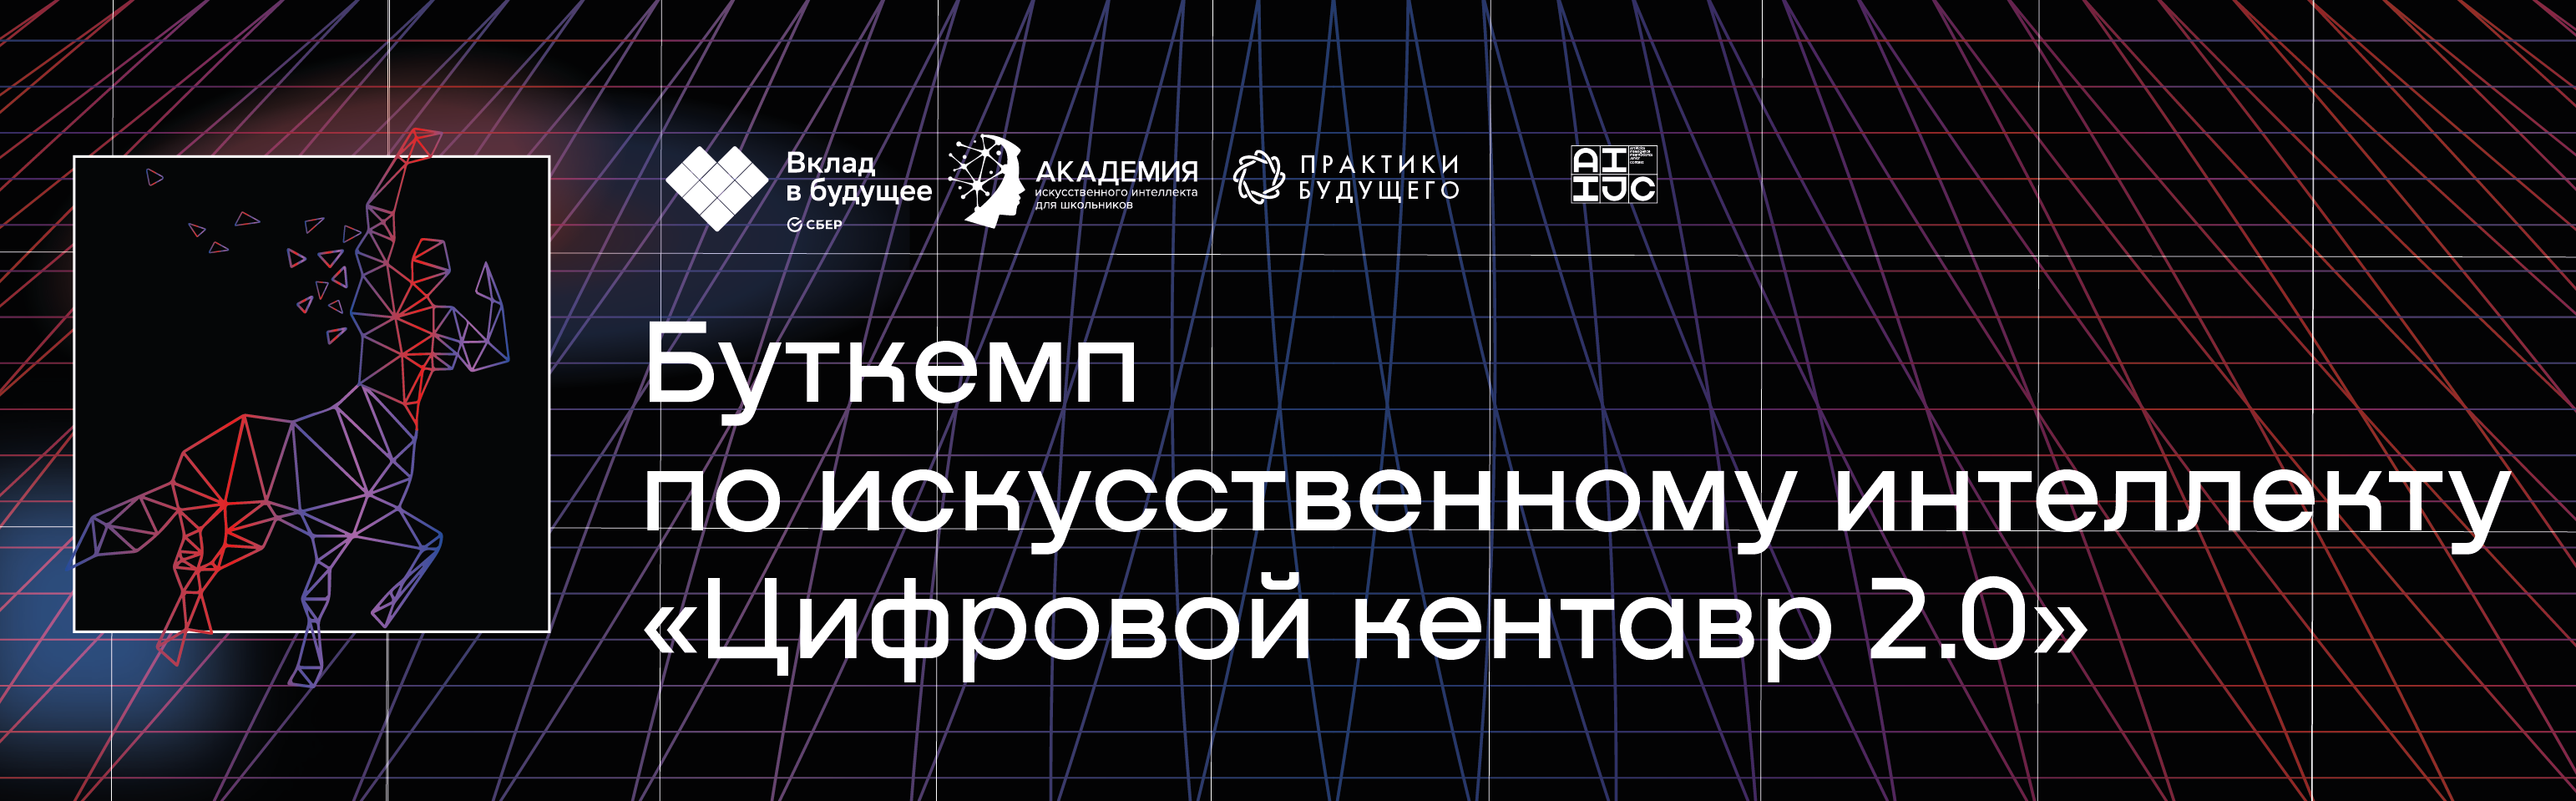

**"Цифры сами по себе не умеют говорить. Именно мы говорим за ним. Мы наполняем их смыслом."
Нейт Сильвер, "Сигнал и шум".**

Визуализация - дополнительный метод для работы с данными. Это то, что может помочь сделать ваши выводы из данных прозрачными, чтобы донести мысли до окружающих. Также это поможет вам лично найти факторы, которые влияют на изменчивость данных. Сделать выводы.

# Всегда иметь в виду 

Избегайте плохих практик!
 
<details>
<summary><b>примеры плохих практик</b></summary>
<br>
<p><img src="https://venngage-wordpress.s3.amazonaws.com/uploads/2017/08/misleading-graphs-infographic.png" alt="image.png"></p>
</details>


# Введение 

Этот ноутбук посвящен обучению визуализации данных на примере датасета, взятого с Kaggle о рейтингах счастья в 153 странах мира. 

Нам понадобятся: 
- `pandas` для работы с данными;
- `matplotlib` и `seaborn` для визуализации;
- `numpy` для нормальной работы с числами, флоутами, NaN-ами, и прочего;
- Собственно, данные.

In [ ]:
import pandas as pd
import numpy as np 

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.gridspec as grid_spec
import seaborn as sns

import warnings
warnings.filterwarnings("ignore") 

## О данных
В ноутбуке используется 3 датасета:
- Данные [Ежегодного доклада о счастье](https://ru.wikipedia.org/wiki/Всемирный_доклад_о_счастье) за 2021 год — это ежегодный доклад, публикуемый подразделением ООН по поиску решений стабильного развития. [Kaggle Source](https://www.kaggle.com/ajaypalsinghlo/world-happiness-report-2021?select=world-happiness-report-2021.csv)
- Исторические данные о Всемирном Индексе счастья с 2005 года. [Kaggle Source](https://www.kaggle.com/ajaypalsinghlo/world-happiness-report-2021?select=world-happiness-report.csv)
- Данные о населении стран за 2020ый год (полагаем, что за год мало что изменилось, на ковид закроем глаза). [Kaggle Source](https://www.kaggle.com/tanuprabhu/population-by-country-2020?select=population_by_country_2020.csv)

При помощи инструментов визуализации мы постараемся найти, почему те или иные страны более "счастливы". Добавить численность населения кажется разумной идеей: посмотрим, зависит ли уровень счастья от численности. 

In [ ]:
# загрузка данных
df1 = pd.read_csv('./world-happiness-report-2021.csv')
df2 = pd.read_csv('./world-happiness-report.csv')
pop = pd.read_csv('./population_by_country_2020.csv')

# Переименовать для унификации обращения
df1.rename(columns={'Country name': 'Country'}, inplace=True)
df2.rename(columns={'Country name': 'Country'}, inplace=True)
pop.rename(columns={'Country (or dependency)': 'Country'}, inplace=True)
df1 = df1.set_index(['Country'])
df2 = df2.set_index(['Country'])
pop = pop.set_index(['Country'])

df1.rename(columns={'Ladder score': 'Ladder Score'}, 
           inplace=True)
df1.rename(columns={'Logged GDP per capita': 'Log GDP per capita'}, 
           inplace=True)
df2.rename(columns={'Life Ladder': 'Ladder Score'}, 
           inplace=True)
df2.rename(columns={'Life Ladder': 'Ladder Score'}, 
           inplace=True)
df2.rename(columns={'Healthy life expectancy at birth': 'Healthy life expectancy'}, 
           inplace=True)


# добавить в исторические данные регион
df2['Regional indicator'] = "undefined region" # на случай, если страны в датасете с которым слияние, нет.
df2.update(df1[['Regional indicator']])

# страны без региона остались: 
# в прошлые годы были страны, которые не попали в репорт 21го года
any(df2['Regional indicator'] == "undefined region") # если True, надо не полениться и самостоятельно дополнить данные

df1 = df1.reset_index(); df2 = df2.reset_index()

## Описание переменных

Давайте разбираться, с какими данными мы имеем дело.
Сопоставим столбцы в исторических данных и в данных за 2021 год:
```
df2.columns.tolist()                   df1.columns.tolist()
'Country',                             'Country',
'year',                                
'Ladder Score',                        'Ladder Score',
'Regional indicator'                   'Regional indicator'
                                       'Standard error of ladder score',
                                       'upperwhisker',
                                       'lowerwhisker',
'Log GDP per capita',                  'Log GDP per capita',
'Social support',                      'Social support',
'Healthy life expectancy',             'Healthy life expectancy',
'Freedom to make life choices',        'Freedom to make life choices',
'Generosity',                          'Generosity',
'Perceptions of corruption',           'Perceptions of corruption',
'Positive affect',                     
'Negative affect',                     
                                       'Ladder score in Dystopia',
                                       'Explained by: Log GDP per capita',
                                       'Explained by: Social support',
                                       'Explained by: Healthy life expectancy',
                                       'Explained by: Freedom to make life choices',
                                       'Explained by: Generosity',
                                       'Explained by: Perceptions of corruption',
                                       'Dystopia + residual',
```
С учётом приведения названий к одинаковым, мы видим, что есть "отсутствующие" переменные. 
Объединяя датасеты, будем учитывать пересечение переменных.

In [ ]:
# добавим 2021 год в исторические данные для упрощения своей жизни 
df1['year'] = 2021
histor_cols = df1.columns.intersection(df2.columns).tolist() 

total_hist_data = pd.DataFrame(columns = histor_cols)
for i in [df1[histor_cols], df2[histor_cols]]:
    total_hist_data = total_hist_data.append(i[histor_cols], ignore_index = 'True')
    
# сотрём ненужный столбец из данных за 2021 год 
df1 = df1.drop(columns=['year'])

    
# Получим "место в рейтинге" для каждой страны для каждого года 
total_hist_data['Rank'] = 0

for year in total_hist_data.year.unique():
    indices = total_hist_data[total_hist_data.year == year].sort_values(by='Ladder Score',
                                                          ascending='False').index
    ranks = sorted([i+1 for i in range(indices.__len__())], reverse=True)
    total_hist_data.loc[indices, ['Rank']] = ranks

Посмотрим, какие в суммарном историческом датасете у нас есть переменные 

`total_hist_data.columns.tolist()`
- **Country:** Страна-участница 
- **Regional indicator:** Регион, к которому относится страна
- **Ladder Score:** значение индекса счастья по опросу
- **Log GDP per capita:** ВВП на душу населения 
- **Social support:** Социальная поддержка населения страны
- **Healthy life expectancy:** Ожидаемая продолжительность жизни
- **Freedom to make life choices:** Свобода принятия решений гражданами
- **Generosity:** Оценка щедрости граждан
- **Perceptions of corruption:** Оценка восприятия коррупции гражданами
- **year:** год опроса
- **Rank:** место страны в рейтинге за год

Переменные, принадлежащие только к одному из двух сетов:
- **Standard error of ladder score:** стандартная ошибка среднего значения индекса счастья\
    $\sigma_\bar{x} = \frac{\sigma}{\sqrt{n}}$\
    $\sigma$ — стандартное отклонение населения\
    $n$ — количество респондентов в опросе\

<details>
<summary><b>Ящик у усами</b></summary>
<br>
<p><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/1a/Boxplot_vs_PDF.svg/1024px-Boxplot_vs_PDF.svg.png" alt="boxplot.png"></p>
</details>

- **upperwhisker:** верхняя граница уса\
    $X_{upp} = Q_3 + 1.5(Q_3 - Q_1)$\
    $Q_1$ — первый квартиль (25 процентиль)\
    $Q_3$ — третий квартиль (75 процентиль)
- **lowerwhisker:** нижняя граница уса\
    $X_{low} = Q_1 - 1.5(Q_3 - Q_1)$\
    $Q_1$ — первый квартиль (25 процентиль)\
    $Q_3$ — третий квартиль (75 процентиль)


- **Ladder score in Dystopia:** оценка населения уровня счастья, находись они в антиутопии
- **Explained by: Log GDP per capita:** преобразованные значения, обработка готовящими отчет
- **Dystopia + residual:** оценка индекса счастья в антиутопии с параметров, специфичных стране
- **Positive affect:** среднее из опроса по: 
    - счастье
    - смех
    - удовлетворение
- **Negative affect:** среднее из опроса по: 
    - беспокойство
    - грусть
    - злость
    
[Подробнее, отчет 2021 года](https://happiness-report.s3.amazonaws.com/2021/Appendix1WHR2021C2.pdf)\
[Подробнее, отчет 2020 года](https://happiness-report.s3.amazonaws.com/2020/WHR20_Ch2_Statistical_Appendix.pdf)

# Табличная репрезентация данных 
Перед тем, как строить графики, надо посмотреть на данные глазами. 

Что мы можем сделать:
- Открыть csv файл
    - недостаток: не будет того, что успели пред-обработать.
- Вывести DataFrame как он есть
- Отсортировать по интересующему столбцу 
    - недостаток: со временными рядами так делать не стоит. 
- Создать новый DataFrame с интересующими данными и поглядеть на него

In [ ]:
# Посмотрим на сырой DataFrame
df1

,Country,Regional indicator,Ladder Score,Standard error of ladder score,upperwhisker,lowerwhisker,Log GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Ladder score in Dystopia,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual
0,Finland,Western Europe,7.842,0.032,7.904,7.780,10.775,0.954,72.000,0.949,-0.098,0.186,2.43,1.446,1.106,0.741,0.691,0.124,0.481,3.253
1,Denmark,Western Europe,7.620,0.035,7.687,7.552,10.933,0.954,72.700,0.946,0.030,0.179,2.43,1.502,1.108,0.763,0.686,0.208,0.485,2.868
2,Switzerland,Western Europe,7.571,0.036,7.643,7.500,11.117,0.942,74.400,0.919,0.025,0.292,2.43,1.566,1.079,0.816,0.653,0.204,0.413,2.839
3,Iceland,Western Europe,7.554,0.059,7.670,7.438,10.878,0.983,73.000,0.955,0.160,0.673,2.43,1.482,1.172,0.772,0.698,0.293,0.170,2.967
4,Netherlands,Western Europe,7.464,0.027,7.518,7.410,10.932,0.942,72.400,0.913,0.175,0.338,2.43,1.501,1.079,0.753,0.647,0.302,0.384,2.798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,Lesotho,Sub-Saharan Africa,3.512,0.120,3.748,3.276,7.926,0.787,48.700,0.715,-0.131,0.915,2.43,0.451,0.731,0.007,0.405,0.103,0.015,1.800
145,Botswana,Sub-Saharan Africa,3.467,0.074,3.611,3.322,9.782,0.784,59.269,0.824,-0.246,0.801,2.43,1.099,0.724,0.340,0.539,0.027,0.088,0.648
146,Rwanda,Sub-Saharan Africa,3.415,0.068,3.548,3.282,7.676,0.552,61.400,0.897,0.061,0.167,2.43,0.364,0.202,0.407,0.627,0.227,0.493,1.095
147,Zimbabwe,Sub-Saharan Africa,3.145,0.058,3.259,3.030,7.943,0.750,56.201,0.677,-0.047,0.821,2.43,0.457,0.649,0.243,0.359,0.157,0.075,1.205


In [ ]:
# Посмотрим на DataFrame, который уже успели немного обработать
total_hist_data

,Country,Regional indicator,Ladder Score,Log GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,year,Rank
0,Finland,Western Europe,7.842,10.775,0.954,72.0,0.949,-0.098,0.186,2021,1
1,Denmark,Western Europe,7.620,10.933,0.954,72.7,0.946,0.030,0.179,2021,2
2,Switzerland,Western Europe,7.571,11.117,0.942,74.4,0.919,0.025,0.292,2021,3
3,Iceland,Western Europe,7.554,10.878,0.983,73.0,0.955,0.160,0.673,2021,4
4,Netherlands,Western Europe,7.464,10.932,0.942,72.4,0.913,0.175,0.338,2021,5
...,...,...,...,...,...,...,...,...,...,...,...
2093,Zimbabwe,Sub-Saharan Africa,3.735,7.984,0.768,54.4,0.733,-0.095,0.724,2016,132
2094,Zimbabwe,Sub-Saharan Africa,3.638,8.016,0.754,55.0,0.753,-0.098,0.751,2017,139
2095,Zimbabwe,Sub-Saharan Africa,3.616,8.049,0.775,55.6,0.763,-0.068,0.844,2018,135
2096,Zimbabwe,Sub-Saharan Africa,2.694,7.950,0.759,56.2,0.632,-0.064,0.831,2019,143


In [ ]:
total_hist_data.sort_values(by=['year', 'Rank']) # сперва по году, потом по месту
total_hist_data.sort_values(by=['Rank', 'year']) # сперва по месту, потом по году

,Country,Regional indicator,Ladder Score,Log GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,year,Rank
598,Denmark,Western Europe,8.019,10.851,0.972,69.600,0.971,NaN,0.237,2005,1
700,Finland,Western Europe,7.672,10.745,0.965,69.760,0.969,-0.005,0.132,2006,1
599,Denmark,Western Europe,7.834,10.891,0.954,69.920,0.932,0.240,0.206,2007,1
600,Denmark,Western Europe,7.971,10.880,0.954,70.080,0.970,0.272,0.248,2008,1
601,Denmark,Western Europe,7.683,10.824,0.939,70.240,0.949,0.264,0.206,2009,1
...,...,...,...,...,...,...,...,...,...,...,...
145,Botswana,Sub-Saharan Africa,3.467,9.782,0.784,59.269,0.824,-0.246,0.801,2021,146
158,Afghanistan,South Asia,2.662,7.697,0.491,52.800,0.427,-0.121,0.954,2017,147
146,Rwanda,Sub-Saharan Africa,3.415,7.676,0.552,61.400,0.897,0.061,0.167,2021,147
147,Zimbabwe,Sub-Saharan Africa,3.145,7.943,0.750,56.201,0.677,-0.047,0.821,2021,148


Определим функции для более красивой визуализации:
- Одноразовые функции имеет смысл объявлять в окрестностях использования 
- Многоразовые - выносить в начало ноутбука, к импортированию пакетов. 

In [ ]:
def color_rank(value):
    if value == 1.0:
        color = 'yellow'
    elif value == 2.0:
        color = 'silver'
    elif value == 3.0:
        color = 'moccasin'
    elif np.isnan(value):
        color = 'black'
    else:
        color = 'default'
    return 'background-color: %s' % color

def highlight_max(data, color='green'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    data = data.astype(float)
    if data.ndim == 1: 
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)

In [ ]:
# При помощи табличной визуализации, найдем "счастивейших" в среднем за последние 16 лет

table_hist_ranks = total_hist_data.pivot(index='Country', columns='year', values=['Rank'])
table_hist_ranks['AVG'] = table_hist_ranks.mean(axis = 1)
table_hist_ranks = table_hist_ranks.sort_values(by = ['AVG'])
table_hist_ranks['Historical Rank'] = range(1, len(table_hist_ranks)+1)
table_hist_ranks.style.applymap(color_rank, 
                                subset = ['Rank', 'Historical Rank']
                               ).format('{:.0f}', 
                                        na_rep='-', 
                                        subset=['Rank']
                                       )
# Ранги мы видим в виде float-ов. Однако, это целочисленные значения.
# Это происходит потому, что в таблице есть значения NaN: not a number.
# Такое значение задано только для чисел с плавающей точкой. 
# Для Int/Int64 и прочих типов данных такая конфигурация бит не ассоцируется ни с бесконечностями, ни с отсутствующими датапоинтами

In [ ]:
# создадим аналогичную таблицу с другими значениями: не местом в году, а с индексом. 
table_hist_score = total_hist_data.pivot_table(index='Country', 
                                        columns='year', 
                                        values=['Ladder Score']
                                       )
table_hist_score = table_hist_score.reset_index()  
table_hist_score['AVG'] = table_hist_score.mean(axis = 1)
table_hist_score = table_hist_score.sort_values(by = ['AVG'], ascending = False)

table_hist_score['Historical Rank'] = range(1, len(table_hist_ranks)+1)
table_hist_score = table_hist_score.set_index(['Country', 'Historical Rank'])

table_hist_score.style.apply(highlight_max).format(na_rep='-', 
                                                   subset=['Ladder Score']
                                                  )

In [ ]:
# таким образом лучше визуализировать нормированные данные, иначе будут "всплески"
df1.describe().T.style\
                       .bar(subset=['mean'], 
                            color='cyan')\
                            .background_gradient(subset=['std'], cmap='magma')\
                            .background_gradient(subset=['50%'], cmap='pink')\
                            .background_gradient(subset=['max'], cmap='Pastel1')\
# https://matplotlib.org/stable/tutorials/colors/colormaps.html
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.io.formats.style.Styler.background_gradient.html

,count,mean,std,min,25%,50%,75%,max
Ladder Score,149.000000,5.532839,1.073924,2.523000,4.852000,5.534000,6.255000,7.842000
Standard error of ladder score,149.000000,0.058752,0.022001,0.026000,0.043000,0.054000,0.070000,0.173000
upperwhisker,149.000000,5.648007,1.054330,2.596000,4.991000,5.625000,6.344000,7.904000
lowerwhisker,149.000000,5.417631,1.094879,2.449000,4.706000,5.413000,6.128000,7.780000
Log GDP per capita,149.000000,9.432208,1.158601,6.635000,8.541000,9.569000,10.421000,11.647000
Social support,149.000000,0.814745,0.114889,0.463000,0.750000,0.832000,0.905000,0.983000
Healthy life expectancy,149.000000,64.992799,6.762043,48.478000,59.802000,66.603000,69.600000,76.953000
Freedom to make life choices,149.000000,0.791597,0.113332,0.382000,0.718000,0.804000,0.877000,0.970000
Generosity,149.000000,-0.015134,0.150657,-0.288000,-0.126000,-0.036000,0.079000,0.542000
Perceptions of corruption,149.000000,0.727450,0.179226,0.082000,0.667000,0.781000,0.845000,0.939000


In [ ]:
total_hist_data[total_hist_data.year == 2015].drop(columns='Rank').describe().T.style\
                       .bar(subset=['mean'], 
                            color='#ff0025')\
                            .background_gradient(subset=['std'], cmap='Greens')\
                            .background_gradient(subset=['50%'], cmap='winter')

,count,mean,std,min,25%,50%,75%,max
Ladder Score,143.000000,5.404035,1.116039,2.702000,4.614500,5.344000,6.279000,7.603000
Log GDP per capita,140.000000,9.396364,1.171620,6.935000,8.470000,9.453000,10.347250,11.617000
Social support,142.000000,0.798204,0.125874,0.434000,0.729250,0.825500,0.900250,0.987000
Healthy life expectancy,139.000000,63.665072,7.167150,46.000000,58.250000,65.500000,68.400000,75.900000
Freedom to make life choices,140.000000,0.748679,0.136423,0.389000,0.655250,0.776000,0.850500,0.980000
Generosity,139.000000,0.019691,0.166158,-0.272000,-0.094500,-0.029000,0.111500,0.688000
Perceptions of corruption,133.000000,0.736526,0.195682,0.095000,0.673000,0.810000,0.862000,0.962000


## Табличная репрезентация: резюме
Визуальизация данных при помощи таблицы (иными словами, посмотреть на данные глазами _правильно_) — первое и самое мощное, что можно сделать перед началом работы, анализа или чего-либо ещё. 

>>> **!!! Смотреть на данные глазками надо до любых .fit() и .predict() !!!**

***
***
Посмотрим на распределения каждой их наших переменных.\
Обратим внимание на то, что гистограмма для `Reginal indicator` не построена.\
Это связано с тем, что тип данных не численный:

In [ ]:
type(df1['Regional indicator'][0])

str

In [ ]:
type(df1['Ladder Score'][0])

numpy.float64

In [ ]:
df1.columns.tolist()

['Country',
 'Regional indicator',
 'Ladder Score',
 'Standard error of ladder score',
 'upperwhisker',
 'lowerwhisker',
 'Log GDP per capita',
 'Social support',
 'Healthy life expectancy',
 'Freedom to make life choices',
 'Generosity',
 'Perceptions of corruption',
 'Ladder score in Dystopia',
 'Explained by: Log GDP per capita',
 'Explained by: Social support',
 'Explained by: Healthy life expectancy',
 'Explained by: Freedom to make life choices',
 'Explained by: Generosity',
 'Explained by: Perceptions of corruption',
 'Dystopia + residual']

***
# Построить графики попросим! 

***
## Корреляции? Корреляции! 
Когда есть много различных переменных, полезно посмотреть, как они попарно кореллируют:\
"Видно ли сильную взаимосвязь между двумя различными параметрами?"

Посмотрим на примере 2021-го года
Для этого отлично подходит heatmap - кроме "сырых" чисел, увидим сильные взаимосвязи и цветом

Для этого мы используем пакет `seaborn`, позволяющий с легкостью решать задачи по визуализации. 
Перед отрисовкой графика всегда полезно задать размеры фигуры, что делается при помощи matplotlib. 

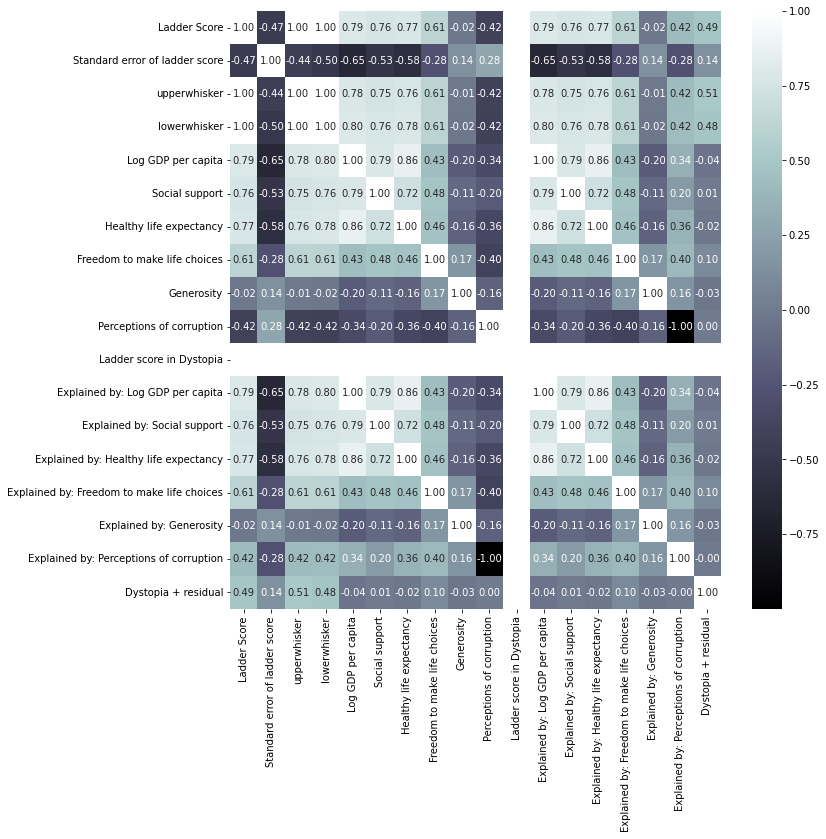

In [ ]:
fig, ax = plt.subplots(figsize=(11, 11)) # создана сетка 1х1

"""
Передаем: 
    - оси, на которые "рисовать" (создано при помощи plpyplot.subplots(figsize=a4_dims)t.subplots)
    - данные (корелляции внутри DataFrame'а с данными о счастье за 2021 гож)
    - аннотировать ли цветокарту значениями (Да)
    - формат аннотации
"""
sns.heatmap(ax=ax, 
            data=df1.corr(), 
            annot = True, 
            cmap='bone', 
            fmt=".2f"
           )
"""
отсюда мы видим, как минимум, что щедрость мало с чем кореллирует
"""
# sns.heatmap(total_hist_data[total_hist_data.year == 2021].corr(), annot = True, cmap='winter')
plt.show()

### Выводы по визуализации корреляций
- Проще посмотреть на цифру
- Проще смотреть на матрицу коэффициентов разом
- Добавление радует глаз и помогает найти "выбросы"
- Не стоит связываться с 2хмерными гистограммами. 
***
## Чертим гистограммы 
Гистограммы позволяют примерно оценить распределение величины. 
Когда мы работаем с DataFrame, у нас есть два способа построения гистрограмм: 
- при помощи метода `df.hist()`
- классическая отрисовка в `matplotlib.pyplot`

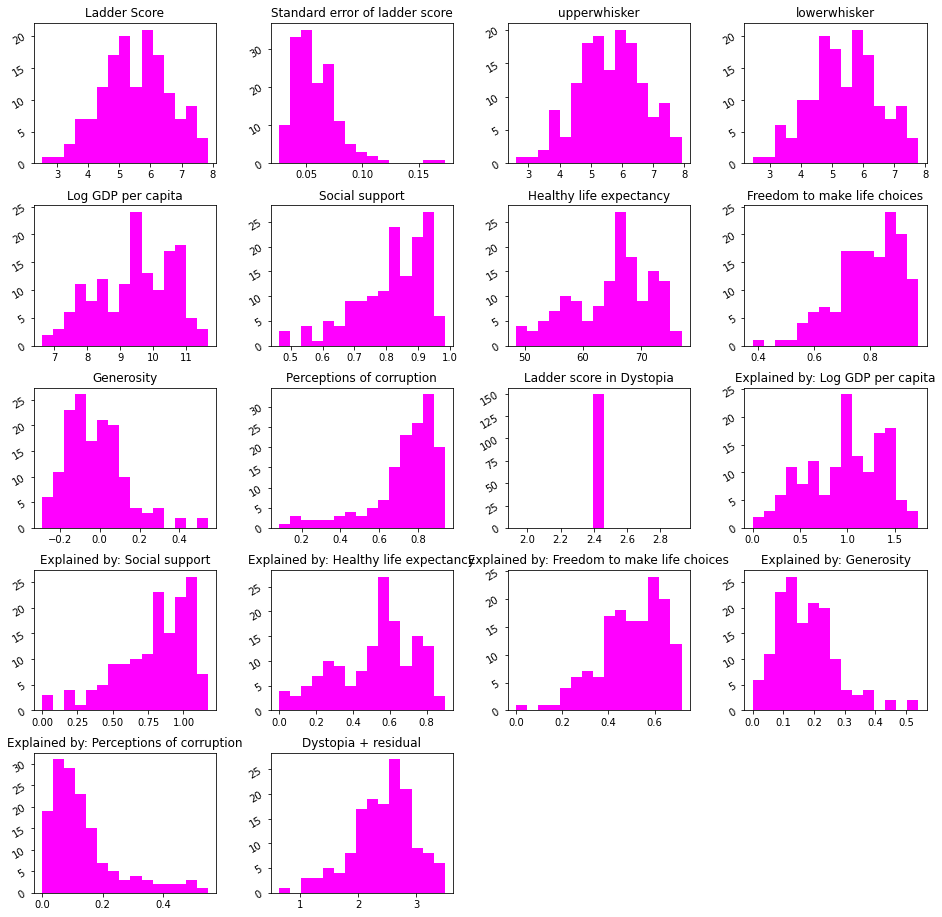

In [ ]:
# другой способ задания размеров, изменяем дефолт значения у matplotlib
plt.rcParams['figure.figsize'] = (16,16)

"""" 
три идентичных function-call'а метода df.hist().
Помним, что метод обращается к matplotlib.pyplot.hist():
    https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.hist.html
    This function calls matplotlib.pyplot.hist(), 
        on each series in the DataFrame, resulting in one histogram per column.
"""
# df1.hist(color="magenta");
# df1[df1.columns.tolist()].hist(color="magenta");
df1[
    ['Country',
     'Regional indicator',
     'Ladder Score',
     'Standard error of ladder score',
     'upperwhisker',
     'lowerwhisker',
     'Log GDP per capita',
     'Social support',
     'Healthy life expectancy',
     'Freedom to make life choices',
     'Generosity',
     'Perceptions of corruption',
     'Ladder score in Dystopia',
     'Explained by: Log GDP per capita',
     'Explained by: Social support',
     'Explained by: Healthy life expectancy',
     'Explained by: Freedom to make life choices',
     'Explained by: Generosity',
     'Explained by: Perceptions of corruption',
     'Dystopia + residual']
].hist(
    color="magenta",
    grid=False,
    legend=False,
    yrot=30,
    bins=15
      );

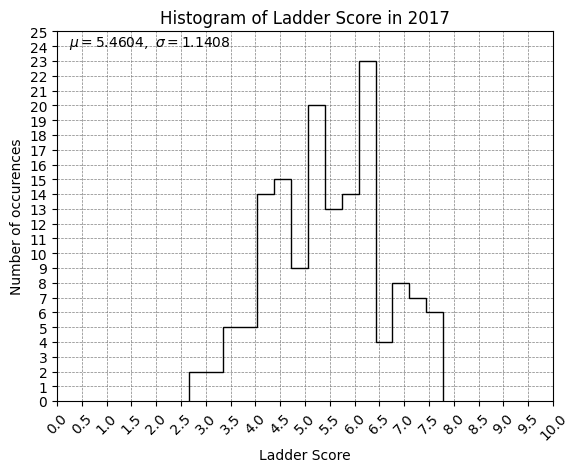

In [ ]:
# возврат дефолтных настроек отображения
plt.style.use('default')

"""
Одна гистограмма в отдельности, используем matplotlib.pyplot
"""

# вынесено в отдельные переменные по нескольким причинам: 
# 1. удобно работать с форматированием стрингов 
# 2. не нужно менять длинный хендл желаемых данных в неск. местах
# 3. в будущем проще сконвертировать скрипт в функцию, если понадобится переиспользовать код 

curr_year = 2017
curr_col_name = 'Ladder Score'
dat = total_hist_data[total_hist_data.year == curr_year][curr_col_name]
ax_cap = (10, 25)

fig, ax = plt.subplots()

ax.hist(dat,
        color="black",
        histtype='step',
        bins=15
        )

plt.xlim(0, ax_cap[0]);ax.set_xticks(np.linspace(0,ax_cap[0],2*ax_cap[0]+1))
plt.ylim(0, ax_cap[1]);ax.set_yticks(np.linspace(0,ax_cap[1],ax_cap[1] + 1))

plt.xticks(rotation=45)
plt.grid(color='grey',
         linewidth=0.5,
         linestyle='--')

plt.title('Histogram of {} in {}'.format(curr_col_name, curr_year))
plt.xlabel(curr_col_name)
plt.ylabel('Number of occurences')
plt.text(0.25, 24, '$\mu={:.4f},\ \sigma={:.4f}$'.format(dat.mean(),dat.std()))

plt.show() # в ноутбуках строчка необязательна

### Выводы для получения гистограмоты 
- Если есть набор данных, посмотри на распределение
- DataFrame пандаса даже имеет метод построения гистограммы на столбец
- Рисовать гистограммы просто
- Главное не недо-/переборщить с количеством интервалов

***
## Чертим столбчатые диаграммы (с 95% уровнем уверенности)
Гистограммы позволяют примерно оценить распределение величины. 
Когда мы работаем с DataFrame, у нас есть два способа построения гистрограмм: 
- при помощи метода `df.hist()`
- классическая отрисовка в `matplotlib.pyplot`
- `seaborn` -- гипер-удобная высокоуровневая "надстройка" над matplotlib для работы со стат. данными

Посмотрим, какой регион наиболее "счастлив". 
Из табличной визуализации мы уже видели, что в топе - Европа, а на последних местах - Африка. Но пока это "качественная" оценка.

Для этого посмотрим на столбчатые диаграммы и на усатые коробки

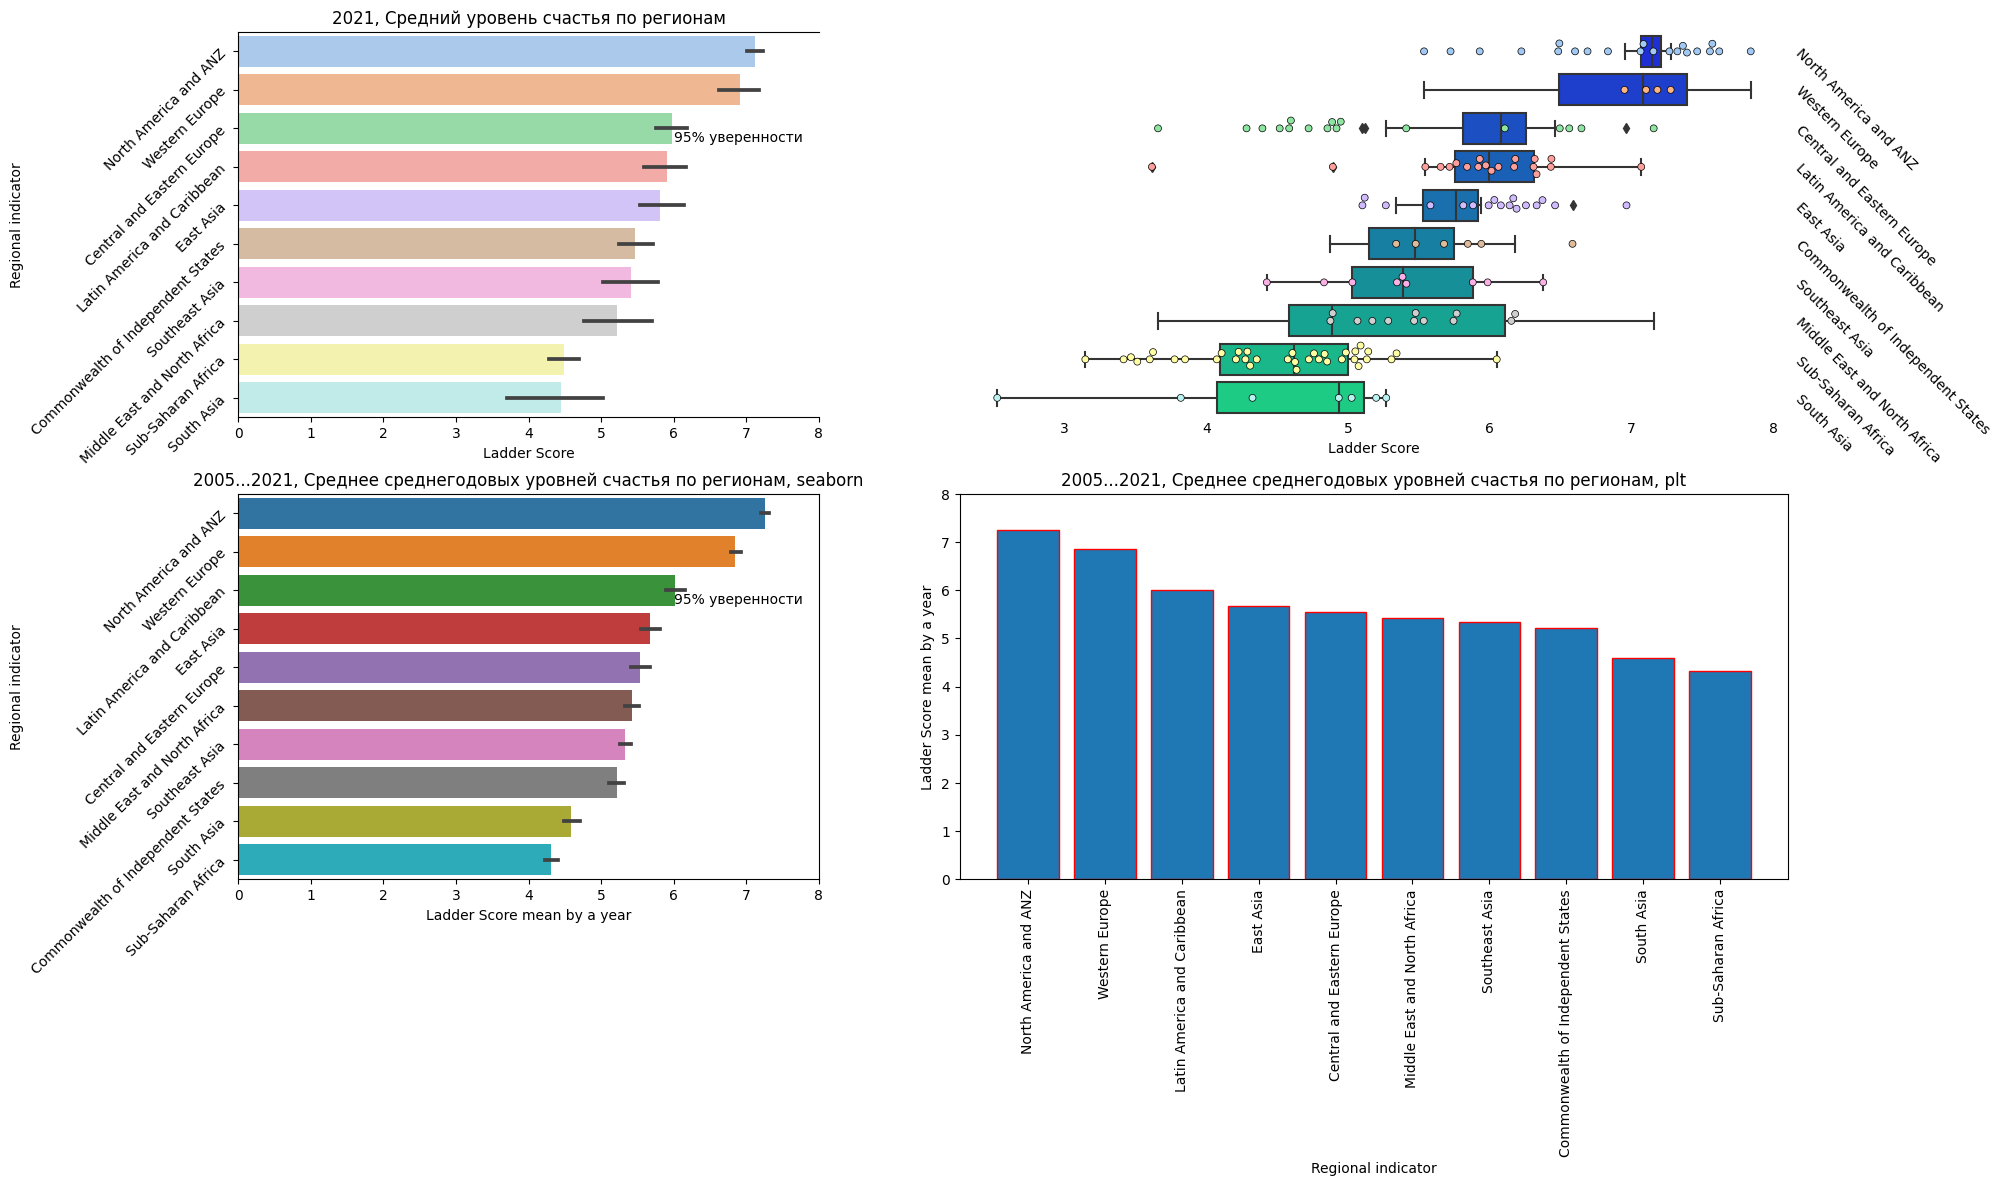

In [ ]:
fig, ax = plt.subplots(ncols=2,
                       nrows=2,
                       figsize=(20, 11),
                       gridspec_kw={'width_ratios': [0.7, 1]}
                      )

mean_ladder_sorted = df1.groupby('Regional indicator').mean()['Ladder Score'].sort_values(ascending=False)
ax[0,0].set_yticklabels(mean_ladder_sorted.index, rotation=45)
ax[0,0].set_title("2021, Средний уровень счастья по регионам")
ax[0,0].set_xlim(0, 8)
ax[0,0].text(6, 2.34, '95% уверенности'.format(1,2))
sns.barplot(y = 'Regional indicator', 
            x = 'Ladder Score', 
            data = df1, 
            order= mean_ladder_sorted.index,
            ax = ax[0,0],
            palette = 'pastel')
# Для разнообразия, уберем границы
ax[0,0].spines['right'].set_visible(False)

# Повторим, но в этот раз - ящики с усами
sns.boxplot(y ='Regional indicator', 
            x ='Ladder Score', 
            data = df1,
            order= mean_ladder_sorted.index,
            ax = ax[0,1],
            palette = 'winter')
    # Добавим дата-семплы поверх усатого ящика
sns.swarmplot(y = 'Regional indicator', 
              x = 'Ladder Score', 
              data =df1, 
              ec='black',
              linewidth=0.5,
              ax = ax[0,1],
              palette='pastel')
ax[0,1].set_yticklabels(mean_ladder_sorted.index, rotation=315)

# Для разнообразия, уберем границы
for s in ['top','left','bottom','right']:
    ax[0,1].spines[s].set_visible(False)
ax[0,1].yaxis.set_label_position("right")
ax[0,1].yaxis.tick_right()
ax[0,1].set_ylabel("") # убираем сгенерированный морерождённым лейбл
ax[0,1].tick_params(axis=u'both', which=u'both',length=0)

# создаем DataFrame со средними значениями ладдер скора для кадого региона, на каждый год
#     каждое вхождение - набор средних для каждого региона в одном году
# Сперва - словарь словарей. 
#     Внешний ключ - aribtrary индекс, некий порядковый номер 
#     Внутренний словарь словарей: 
#         {'Regional indicator' : 'Antarctica',       Регион
#          'year' : 2005,                             Год
#          'Ladder Score mean by a year' : 10.0       Среднее знаение ладдер скора стран региона в году
#         }

idx = 0
dict_ladders_by_yr = {}
for region in total_hist_data['Regional indicator'].unique():
    for yr in sorted(total_hist_data['year'].unique()):
        dict_ladders_by_yr[idx] = {'Regional indicator' : region,
                                   'year' : yr,
                                   'Ladder Score mean by a year' : total_hist_data[total_hist_data['year'] == yr]\
                                                                      [total_hist_data['Regional indicator'] == region]\
                                                                      ['Ladder Score']\
                                                                   .mean()
                                  }
        idx += 1

df_by_yrs = pd.DataFrame(dict_ladders_by_yr).transpose()
df_by_yrs = df_by_yrs.drop(df_by_yrs[df_by_yrs['Regional indicator'] == 'undefined region'].index)
by_yrs_mean_ladder_sorted = df_by_yrs.groupby('Regional indicator').mean()['Ladder Score mean by a year'].sort_values(ascending=False)

ax[1,0].set_yticklabels(mean_ladder_sorted.index, rotation=45)
ax[1,0].set_title("2005...2021, Среднее среднегодовых уровней счастья по регионам, seaborn")
ax[1,0].set_xlim(0, 8)
ax[1,0].text(6, 2.34, '95% уверенности'.format(1,2))
sns.barplot(y = 'Regional indicator', 
            x = 'Ladder Score mean by a year', 
            data = df_by_yrs, 
            order= by_yrs_mean_ladder_sorted.index,
            ax = ax[1,0])

# Повторим бар-чарт, с использовнием классического мат-плот-либ, горизонтально
# дополнительно можно дорисовать интервалы ошибок при помощи xerr, yerr 
#      но seaborn умеет это делать за нас: 
#      мы передаем ему данные, он считает за нас среднее и разброс. + умеет работать с пандас.

df_by_yrs = df_by_yrs.set_index('Regional indicator')
mean_mean_dict = {}
for reg in df_by_yrs.index.unique(): 
    mean_mean_dict[reg] = df_by_yrs[df_by_yrs.index == reg]['Ladder Score mean by a year'].mean()
mean_mean_dict = {k: v for k, v in sorted(mean_mean_dict.items(), key=lambda item: item[1], reverse=True)}

ax[1,1].bar([k for k in mean_mean_dict.keys()], 
            [v for v in mean_mean_dict.values()], 
            edgecolor='red')
ax[1,1].set_xticklabels([k for k in mean_mean_dict.keys()], rotation=90)
ax[1,1].set_ylim(0, 8)
ax[1,1].set_title("2005...2021, Среднее среднегодовых уровней счастья по регионам, plt")
ax[1,1].set_xlabel("Regional indicator")
ax[1,1].set_ylabel("Ladder Score mean by a year")

"""
На смежных графиках наилучшая практика - совмещать границы осей
"""
plt.show()

### Резюмируем столбцы и усы
- Совмещение scatter-plot'a и усатого ящика даёт хорошее понимание устройства данных
- На доверительных интервалах "выбросов" не увидишь 
- Соседние графики очень просто сравнивать, когда:
    - Начала осей совмещениы
    - Оси одинаковы
    - Данные "однородны"
- `seaborn` -- мощный инструмент, упрощающий жизнь
***
## А что, если не гистограмму, а плотность вероятности при помощи ядерной оценки плотности? 
Ядро - некая функция в базе распределения случайной величины.\ 
Для нормальных распределений -- гауссиана.\
Существуют бимодальные, равномерные и другие распределения 

KDE - Kernel Density Estimation -- ядерная оценка плотности -- способ "прикинуть" плотность распределения функции, подбирая с разными ввесами разные функции ядра (гауссиана, равномерное и другие)

![Ядра](https://upload.wikimedia.org/wikipedia/commons/thumb/4/47/Kernels.svg/590px-Kernels.svg.png)

ОЧЕНЬ грубо говоря, KDE "описывает", "оборачивает" гистограмму.\
Взаимосвязь аналогична паре аналогового и оцифрованного сигнала 

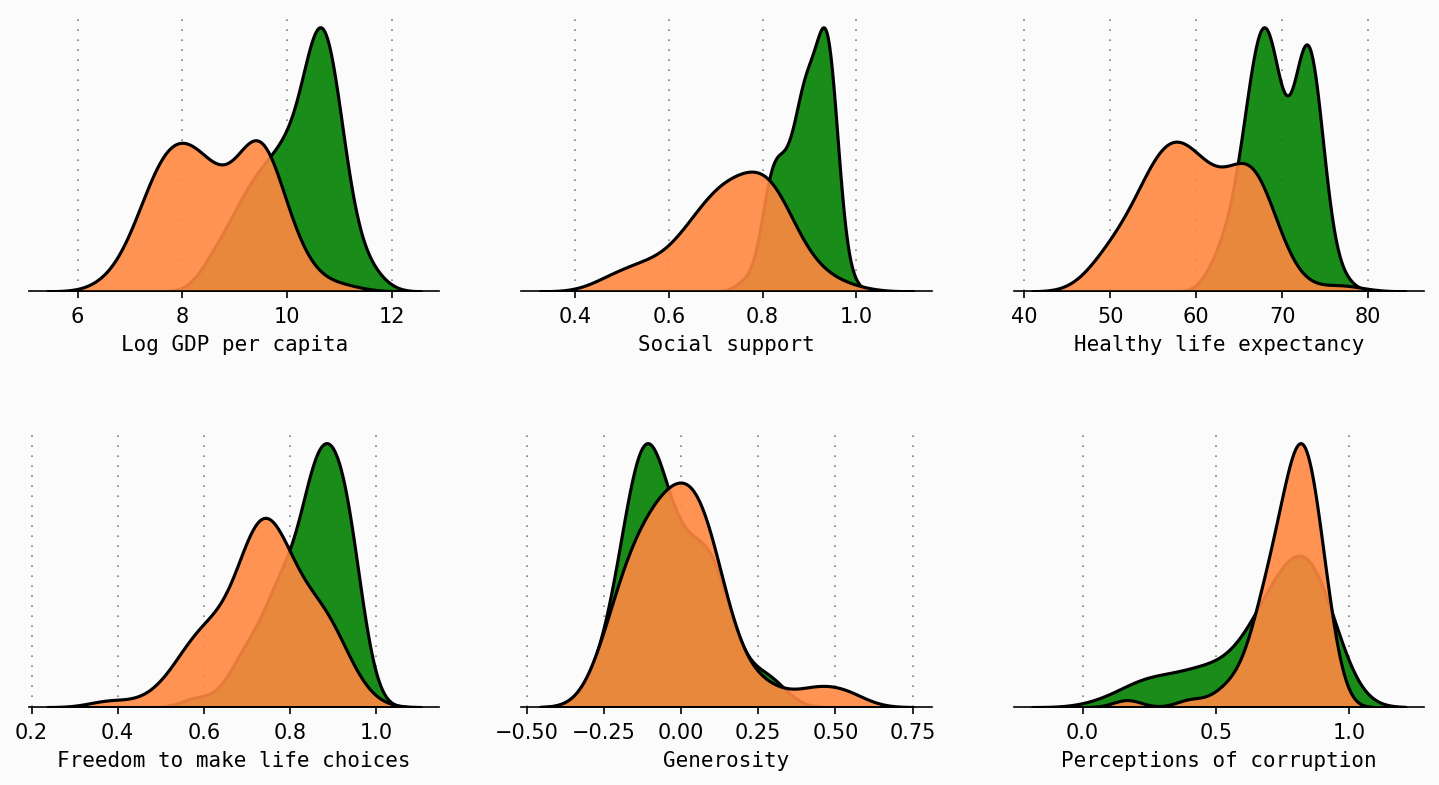

In [ ]:
background_color = '#fbfbfb'
fig = plt.figure(figsize=(12, 6), dpi=150,facecolor=background_color)
gs = fig.add_gridspec(2, 3)
gs.update(wspace=0.2, hspace=0.5)


plot = 0
for row in range(0, 2):
    for col in range(0, 3):
        locals()["ax"+str(plot)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(plot)].set_facecolor(background_color)
        locals()["ax"+str(plot)].tick_params(axis='y', left=False)
        locals()["ax"+str(plot)].get_yaxis().set_visible(False)
        locals()["ax"+str(plot)].set_axisbelow(True)
        for s in ["top","right","left"]:
            locals()["ax"+str(plot)].spines[s].set_visible(False)
        plot += 1

plot = 0

happiness_mean = df1['Ladder Score'].mean()
moddf1 = df1.copy()
moddf1['lower_happy'] = moddf1['Ladder Score'].apply(lambda x: 0 if x < happiness_mean else 1)

Yes = moddf1[moddf1['lower_happy'] == 1]
No = moddf1[moddf1['lower_happy'] == 0]

for param in total_hist_data.columns.tolist()[3:-2]:
        sns.kdeplot(Yes[param], ax=locals()["ax"+str(plot)], color='Green',ec='black', shade=True, linewidth=1.5, alpha=0.9, zorder=3, legend=False)
        sns.kdeplot(No[param],ax=locals()["ax"+str(plot)], color='#ff8841', shade=True, ec='black',linewidth=1.5, alpha=0.9, zorder=3, legend=False)
        locals()["ax"+str(plot)].grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1,5))
        locals()["ax"+str(plot)].set_xlabel(param, fontfamily='monospace')
        plot += 1
        
Xstart, Xend = ax0.get_xlim()
Ystart, Yend = ax0.get_ylim()

"""
There are large differences, with GDP & Social Support being clear\nperhaps more interesting though, unhappy countries appear to be more generous
В счастливых ниже среднего ВВП кажется ниже, социальное обеспечение  - аналогично
Восприятие коррупции мало влияет (мы это видели и на корреляциях
Менее счастливые страны кажутся более "щедрыми"
"""

plt.show()

In [ ]:
total_hist_data.columns.tolist()[3:-2]

['Log GDP per capita',
 'Social support',
 'Healthy life expectancy',
 'Freedom to make life choices',
 'Generosity',
 'Perceptions of corruption']